<h1><center> MLP MNIST Training </center></h1>






### Cristiano De Nobili - My Contacts
For any questions or doubts you can find my contacts here:

<p align="center">

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Instagram_logo_2016.svg/2048px-Instagram_logo_2016.svg.png" width="20">](https://www.instagram.com/denocris/?hl=it)
[<img src="https://1.bp.blogspot.com/-Rwqcet_SHbk/T8_acMUmlmI/AAAAAAAAGgw/KD_fx__8Q4w/s1600/Twitter+bird.png" width="30">](https://twitter.com/denocris) 
[<img src="https://loghi-famosi.com/wp-content/uploads/2020/04/Linkedin-Simbolo.png" width="40">](https://www.linkedin.com/in/cristiano-de-nobili/)     

</p>

or here (https://denocris.com).

### Useful Links

All notebooks can be found [here!](https://drive.google.com/drive/folders/1i3cNfzWZTNXfvkFVVIIDXjRDdSa9L9Dv?usp=sharing)

Introductory slides [here!](https://www.canva.com/design/DAEa5hLfuWg/-L2EFFfZLVuiDkmg4KiKkQ/view?utm_content=DAEa5hLfuWg&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink)

Collection of references: [here!](https://denocris.notion.site/Deep-Learning-References-0c5af2dc5c8d40baba19f1328d596fff)


### Tools used 

PyTorch, NumPy, sklearn. To perform grid search we will use the Optuna optimization library.

### Notebook Outline

* information theory background;
* write and train a MLP on MNIST using hold-out validation;
* implement grid search with Optuna;
* learn k-fold cross-validation.



## Packages and GPU Settings

In [ ]:
%%capture
!pip install -q tensorboard
!pip install -q optuna 

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchsummary import summary


from matplotlib import pyplot as plt
import numpy as np
import random
import optuna

GPU info e device set up

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan  2 20:32:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

## Information Theory Background 


Basic notions of Information Theory are essetial for the understanding of many machine/deep learning mechanisms as we will see in a while.

### Self-Information

Every event takes with it an ammount of self-information. The idea behind self-information goes as follows

* if an event always occurs, we associate it with a smaller amount of information. It will not suprise us!
* On the other side, a rare event is associated with a huge amount of information. It will suprise us!

I am not surprise to see the sunrise every morning (likely event). Instead,  I would be really suprised if tomorrow the Sun will not rise (unlikely event). This amount of surprise or self-information of the event $x$ is quantified by

$$I(x) = - \log p(x),$$

where $p(x)$ is the probability of the event $x$. If $p(x)=1$, then self-info is zero. A rare event instead has a huge surpise factor.

### Shannon Entropy 

Here the original paper by Claude Shannon (1948): [A Mathematical Theory of Communication](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf).

In terms of self-info, Shannon Entropy is the average self-information (expected value) over all possible values of X.
The entropy for a probability $p(x)$ distribution is

$$ S = - \sum_i p(x_i) \log p(x_i),$$

where we assume we know the probability $p$ for each outcome $i$ and $ \sum_i p(x_i)=1$. If we use $log_2$ for our calculation we can interpret entropy as *the minimum number of bits it would take us to encode our information*.

For continous variables, we can use the integral form

$$ S = - \int  p(x) \log p(x) \, dx,$$

where now $p(x)$ is taking the role of a probability density function (PDF). Take in mind that a broad probability density has higher entropy than a narrowed one (think about Gaussian distribution vs delta Dirac, which has $S=0$).

In both discrete and continous formulation, we are computing the expectation (i.e. average) of the negative log-probability (i.e. self-info) which is the theoretical minimum encoding size of the information from the event $x$. The same formula is usually written as

$$S = \mathbb E _{\, x \sim p} \left[ -\log p(x) \right],$$

where $x \sim p$ means that we calculate the expectation with the probability distribution $p$.

Let's give an example! 

<!---
  REMIND to change open with uc
 https://drive.google.com/open?id=1Y52T3Z4dwRU4Rq5L5bEVYh0d3kU0aVB8
--->

  <center>  <img src=https://drive.google.com/uc?id=1GaAeK8xIZCVDRb-oHQNUzRuoOprFh1eS " width="700">  </center> 

Let us say we have to pass a message about what drink Cristiano will order during an event. In general, Cristiano loves [Midori Sour](https://drizly.com/midori-sour/r-b972d5282bec6fe8) , Daiquiri, Spritz and Wine.

On Monday, Cristiano loves to listen Jazz and the probability distribution of his choice is: 

$$P(\text Midori ) =  P(\text Daiquiri ) = P(\text Spritz ) = P(\text Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} = 2$$

On Wednesday, he usually meets with some friends after work: 

$$P(\text Midori ) = 0.125,\;  P(\text Daiquiri ) =0.125,\;  P(\text Spritz ) = 0.5,\; P(\text  Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{8} \log \frac{1}{8} - \frac{1}{8} \log \frac{1}{8} - \frac{1}{2} \log \frac{1}{2} - \frac{1}{4} \log \frac{1}{4} = 1.75$$


On Thursday, he often goes to an event where cocktail attire dress code is required

$$P(\text Midori ) = 0.95,\;  P(\text Daiquiri ) =0.02,\;  P(\text Spritz ) = 0.018,\; P(\text  Wine ) = 0.012,$$

and the corresponding entropy

$$S = - 0.95 \log 0.95 - 0.02 \log 0.02 - 0.018 \log 0.018 - 0.012 \log 0.012 = 0.364$$

In [ ]:
# On Monday, all drinks have equal probability to be chose
entropy_1 = -0.25*np.log2(0.25)-0.25*np.log2(0.25)-0.25*np.log2(0.25)-0.25*np.log2(0.25)
print('On Monday, high entropy: ', entropy_1)

# On Wednesday, some are more probable than others
entropy_2 = -0.5*np.log2(0.5)-0.25*np.log2(0.25)-0.125*np.log2(0.125)-0.125*np.log2(0.125)
print('On Wednesday, medium entropy: ', entropy_2)

# On Thursday, one drink is by far the most probable
entropy_3 = -0.95*np.log2(0.95)-0.02*np.log2(0.02)-0.018*np.log2(0.018)-0.012*np.log2(0.012)
print('On Thursday, low entropy: ', entropy_3)

On Monday, high entropy:  2.0
On Wednesday, medium entropy:  1.75
On Thursday, low entropy:  0.36407300467232967


If entropy is high (encoding size $log_2 p(x)$ is big on average), it means we have many message types with small and almost equal probabilities. Hence, every time a new message arrives, you would expect a different type than previous messages. You may see it as a disorder or uncertainty or unpredictability.

On the contrary, when a message has much smaller probability than other messages, it appears as a surprise because on average you would expect other more frequently sent message types. Moreover, a rare message type has more information than more frequent message types because it eliminates a lot of other probabilities and tells us more specific information.

In the drink scenario, by sending “Wine” on thursday which happens 1.2% of the times, we are reducing the uncertainty by 98.8% of the probability distribution (“Midori, Daiquiri, Spritz”) provided we had no information before. If we were sending “Midori” (95%) instead, we would be reducing the uncertainty by 5% only.

If the entropy is high (ex: fair coin), the average encoding size is significant which means each message tends to have more (specific) information. Again, this is why high entropy is associated with disorder, uncertainty, surprise, unpredictability, amount of information. The more random a message is, the more information will be gained from decoding the message.

Low entropy (ex: sunrise) means that most of the times we are receiving the more predictable information which means less disorder, less uncertainty, less surprise, more predictability and less (specific) information. This is the Thursday case.

### Cross Entropy

Suppose to have two distributions, the true one $p(x)$ and the estimated $q(x)$. In the language of neural networks, $p(x)$ would be the grond truth (labels in one hot-encoding) and $q(x)$ the outcome of the net, i.e. the one that your machine learning algorithm is trying to match. Cross entropy is a mathematical tool for comparing two probability distributions $p(x)$ and $q(x)$ and it is expressed by the formula 

$$ H (p,q) = - \int p(x) \log q(x)\,dx.$$

If $\log$ is in base $2$, then cross entropy measures the number of bits you will need encoding symbols from $p$ using the wrong distribution $q$. Subtracting to cross entropy the entropy of $p$, you are counting the cost in terms of bits of using the wrong distribution $q$ (this somehow will be KL-divergence). An important property of cross-entropy is that its value is minimum (and corresponds to $H(p)$) when $p(x)=q(x)$. That is the reason why, during training we want to minimize its value. This corresponds to force the estimated distribution $q(x)$ to be close to the true one $p(x)$.

### Kullback-Leibler Divergence

KL-divergence is just a slight modification of our formula for entropy. Rather than just having our probability distribution $h$ we add into the game our approximating distribution $g$. Then we look at the difference of the log values for each

$$D_{KL}(h || g) =  \sum_i h(x_i) (\log h(x) - \log g(x)) = \sum_i h(x_i) \log \frac{h(x)}{g(x)}$$ 

from which

$$H(h, g) =  H(h) + D_{KL}(h || g).$$ 


KL-divergence is the expectation of the log-difference between the probability of data in the original distribution $h$ with the approximating distribution $g$. Again, if we think in terms of $\log_2$ we can interpret this as how many bits of information we expect to lose when we choose an approximation $g$ of our original ditribution $h$. 

In the variational autoencoder loss function, the KL-divergence is used to force the distribution of latent variables $q(z | x)$ to be a normal distribution $n(z)$ so that we can sample latent variables from the normal distribution. As such, the KL-divergence is included in the loss function to improve the similarity between the distribution of latent variables and the normal distribution. More about **KL** can be found [here](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) and about **cross-entropy** [here](https://towardsdatascience.com/demystifying-cross-entropy-e80e3ad54a8).

## Training, Validation and Test Sets

* **parameters:** weights and biases of a DNN which transform the input before applying the activation function. Each layer has its own set of parameters. The parameters are adjusted through backpropagation to minimize the loss function or in other words are learned during the training process;

* **hyperparameters:** unlike parameters, their values are not adapted by the learning algorithm itself. They can be viewed as settings that can be used to control the behaviour of the algorithm. Examples are number of layers, type of architecture, batch size, learning rate, etc...;

* **training set:** a set of examples used for learning. It affects parameters ann in particular they are optimized according to this set;

* **validation set:** a set of examples not seen by the model during training. It is like a mini-test set that provides feedback to the model during training on how well the current weights generalize beyond the training set. It does not impact or adjust weights directly, but providing information about overfitting it can indirectly impact weights if some regularization techniques are applied. In addition, validation set is widely used to tune hyperparameters;

* **test set:** a set of examples used at the end of training and validation to assess the predictive power of your model.

## A Complete Training of a MLP Model on MNIST Dataset

In this section, we want to show a complete train of a MLP network . We will show the following pipelines

* Import, preprocess and properly normalize training and test data;
* Build up the MLP and init its weights;
* Train and evaluate the model using standard hold-out validation;
* Tune hyperparameters with Optuna;
* Train and evaluate the model using K-Fold Cross-Validation.

## Train MLP Model with hold-out validation

### Import and Preprocess Data

MNIST is a dataset for handwritten digit recognition.

* The dataset is composed of 60,000 grayscale images
  * by default, the dataset is already split into a training set of 50,000 images, while the remaining 10,000 images make up the test/validation set
* Each image is composed of 28x28 pixel
* Only one digit is present in each image
  * thus, we will be classifying digits from 0 to 9 (10 classes)
* The digit is centered within the image

From **torchvision** we import the MNIST dataset 

In [ ]:
%%capture
#Download data
train_set = MNIST('./data', train=True, download=True)
test_set = MNIST('./data', train=False, download=True)

In [ ]:
train_set.data.numpy().shape

(60000, 28, 28)

In [ ]:
# First image in dataset
img = train_set.data.numpy()[0]
img.shape

(28, 28)

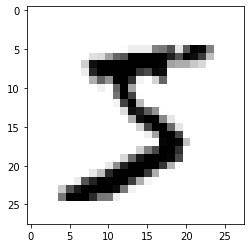

In [ ]:
plt.imshow(img, interpolation="nearest", cmap="gray_r")

In [ ]:
imgs = train_set.data.numpy()[0:5]
imgs.shape

(5, 28, 28)

Applying a reshape we can view more than one sample

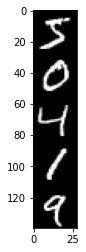

In [ ]:
# use this trick
multi_img_reshaped = imgs.reshape(5*28, 28)
plt.imshow(multi_img_reshaped, cmap="gray")

Normally, digital pixels have values from $0$ to $255$. On the other side, neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. Therefore it is a good practice to normalize input to small values. We will apply the centering procedure, that consist of dividing first all pixel values by the highest value $255$. Then, we subtract the mean value and dividing by the standard deviation.

As a first step, let us compute mean and standard deviation of MNIST training dataset:

In [ ]:
train_set_array = train_set.data.numpy() / 255.0
test_set_array = test_set.data.numpy() / 255.0

print('Train mean and std: %f  %f' %(train_set_array.mean(), train_set_array.std()))
print('Test mean and std: %f  %f' %(test_set_array.mean(), test_set_array.std()))

Train mean and std: 0.130660  0.308108
Test mean and std: 0.132515  0.310480


Now we go on with three steps:

* Set random seeds;
* Apply **transforms** ([Official Docs](https://pytorch.org/vision/stable/transforms.html)) which allows a set of common image transformations that can be composed;
* Use `DataLoader`, that combines a dataset and a sampler, and provides an iterable over the given dataset. It handles the dataset in mini-batch for Stochastic Gradient Descent.

In [ ]:
# set the seed: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
batch_size = 16

transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize( (0.1307,), (0.3081,))])

# DataLoader: combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(MNIST(root = './data', train = True, transform = transform, download=True), batch_size=batch_size , shuffle=False)
# Splitting the test images (tot 10k) in valid and test set.
valid_loader_tmp, test_loader_tmp = random_split(MNIST(root = './data', train = False, transform = transform, download=True), [7000, 3000]) 

valid_loader = DataLoader(valid_loader_tmp, batch_size=batch_size , shuffle=False)
test_loader = DataLoader(test_loader_tmp, batch_size=batch_size , shuffle=False)

In [ ]:
# check for seed = 172
imgs_check = next(iter(valid_loader))
np.array_equal(imgs_check[1].numpy() , np.array([1, 4, 6, 5, 9, 7, 3, 4, 7, 0, 2, 1, 9, 7, 6, 4]))

True

**A good practice** is to normalize the test set using the training normalization parameters (mean and std).

We want testing data points to represent real-world data that the network has never seen. If we take the mean and variance of the whole dataset we will be introducing future information into the training explanatory variables (i.e. the mean and variance).

Therefore, you should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.

To better understand imagine now that we have trained our model and we are on a production where new data keep coming for prediction. We might not get them in mass, but one by one such as in an API call. We do not have the mean and standard deviation of those new data. We only have the mean and std during the training process.  To sum up, the goal is to be as close as possible to real problems. Therefore, during training we should not use any knowledge we get from the test data.

###MLP Model

The idea is to introduce a few concepts, build up a pipeline and be as clear as possible. 

In [ ]:
# write here the class for your MLP
class MLP(nn.Module):
    def __init__(self, dropout_rate = .2):
        super().__init__()


        self.flat = torch.nn.Flatten() # X comes in as a n x 1 x 28 x 28 -> we need n 784-size vectors (or, a n x 784 matrix). flatten does this
        self.layer1 = torch.nn.Linear(784, 16)
        self.layer2 = torch.nn.Linear(16, 32)
        self.layer3 = torch.nn.Linear(32, 24)
        self.layer4 = torch.nn.Linear(24, 10)
        
        self.droput = nn.Dropout2d(p = dropout_rate)


    def forward(self, X): 
        out = self.flat(X)
        out = self.layer1(out)
        out = torch.nn.functional.relu(out)
        out = self.layer2(out)
        out = torch.nn.functional.relu(out)
        out = self.layer3(out)
        out = torch.nn.functional.relu(out)
        out = self.droput(out)
        logits = self.layer4(out)
        # out = torch.nn.functional.softmax(out) -> this is wrong since we will use NegativeLogLikelihood Loss
        # softmax transforms a vector into a simplex (vector of positive nums summing to 1): 
        # [1,2,3,4] -> [0.1, 0.2, 0.3, 0.4]
        # instead we need the logsoftmax
        #out = torch.nn.functional.log_softmax(out)
        return logits

### Weights Initialization

We will now initialize weights (and biases) using Xavier initialization. If you are more interested in understanding its details, you can find here the origina paper by [Xavier and Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

There are several ways to initialize parmeters. However, the most naively ones might cause vanishing gradinet effects during training. Researchers finded more safe initializations. One of them is Xavier initialization.
It sets a layer’s weights to values chosen from a random uniform distribution that is bounded between


$$\pm \frac{\sqrt{6}}{\sqrt{n_i+n_{i+1}}}, $$

where $n_i$ is the number of incoming network connections, or *fan-in*, to the layer, and $n_{i+1}$ is the number of outgoing network connections from that layer, also known as the *fan-out*. We are going to use it for weights initialization (`nn.init.xavier_uniform_(m.weight)`). For biases initialization instead we will adopt a slightly different approach, just to show you how you can play with initializations.

In [ ]:
def weight_init(m):
    torch.manual_seed(seed) 
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)

In [ ]:
model = MLP(dropout_rate = 0.2)
#lenet = MLP(dropout_rate = 0.000001)

# apply weight init
model.apply(weight_init)

# put the model on the device
model.to(device) 


MLP(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=24, bias=True)
  (layer4): Linear(in_features=24, out_features=10, bias=True)
  (droput): Dropout2d(p=0.2, inplace=False)
)

In [ ]:
# check that the model is working
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 16]          12,560
            Linear-3                   [-1, 32]             544
            Linear-4                   [-1, 24]             792
         Dropout2d-5                   [-1, 24]               0
            Linear-6                   [-1, 10]             250
Total params: 14,146
Trainable params: 14,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


To keep under control all steps

In [ ]:
torch.save(model.state_dict(), './weights_init')

list(model.parameters())[0]

Parameter containing:
tensor([[-0.0438, -0.0506,  0.0692,  ..., -0.0128,  0.0556,  0.0760],
        [-0.0749,  0.0550, -0.0272,  ..., -0.0708,  0.0174,  0.0558],
        [-0.0713,  0.0166,  0.0674,  ..., -0.0340, -0.0851,  0.0855],
        ...,
        [-0.0401, -0.0709, -0.0674,  ...,  0.0730,  0.0402, -0.0470],
        [-0.0060, -0.0686, -0.0389,  ..., -0.0635, -0.0832,  0.0736],
        [ 0.0243, -0.0643, -0.0081,  ..., -0.0625, -0.0108,  0.0190]],
       device='cuda:0', requires_grad=True)

### Training and Evaluation

Let us first define 

* a function that computes accuracy from logits (applying a softmax function);

* a function that computes evaluation.

Logits are the unnormalized final scores (predictions) of our model. We must apply softmax to it to get a probability distribution over our classes. If you remind, the LeNet() class returns logits


In [ ]:
def get_accuracy_from_logits(logits, labels):
    softmax = nn.Softmax(dim=1)
    argmax = torch.argmax(softmax(logits.float()), dim=1)
    pred_class = argmax.long()
    acc = (pred_class == labels.long()).float().mean()
    return acc

def evaluate(net, crit, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            logits = net(data)
            mean_loss += crit(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [ ]:
len(train_loader) # 3750*batch_size

3750

In [ ]:
# The SummaryWriter class is your main entry to log data for consumption and visualization by TensorBoard.
writer = SummaryWriter() # it will output to ./runs/ directory by default

def training(model, train_loader, valid_loader, optim, crit, epochs, device, model_save = True):
    # set up the model on training phase
    model.train()
    best_acc = 0
    tot_len = len(train_loader)
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, labels) in enumerate(train_loader):
            # transfer data on the device
            data, labels = data.to(device), labels.to(device)
            #Clear gradients  
            # Since the backward() function accumulates gradients, and you do not want to mix up 
            # gradients between different batches, you have to zero them out at the start of a new batch.
            optim.zero_grad()
            logits = model(data)
            loss = crit(logits, labels)
            loss.backward()
            optim.step()
            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                writer.add_scalars('Loss', {'train': loss.item()}, batch_idx + tot_len*(epoch-1))

            if batch_idx % 500 == 0:
                _, valid_loss = evaluate(model, crit, valid_loader, device)
                writer.add_scalars('Loss', {'valid': valid_loss}, batch_idx + tot_len*(epoch-1))
                # set again the model to train mode
                model.train()
    
        valid_acc, _ = evaluate(model, crit, valid_loader, device)
        #writer.add_scalar('Accuracy', valid_acc, tot_len + tot_len*(epoch-1))
        writer.add_scalars('Acc', {'valid': valid_acc}, tot_len + tot_len*(epoch-1))

        if valid_acc > best_acc:
          print("Best validation accuracy improved from {} to {}, saving model...".format(best_acc, valid_acc))
          best_acc = valid_acc
          if model_save:
            torch.save(model.state_dict(), 'Models/lenet_{}.pt'.format(epoch))

    return best_acc
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            test_loss += criterion(output, labels).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
#!rm -rf runs
#!rm -rf Models

In [ ]:
epochs = 3
!mkdir Models


Let us train the MLP model

In [ ]:
# define loss function
criterion = nn.CrossEntropyLoss() # The input is expected to contain raw, unnormalized scores for each class (logits)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 

kwargs = {'optim': optimizer, 'crit': criterion, 
          'epochs': epochs, 'device': device}

training(model, train_loader, valid_loader, **kwargs)

writer.close()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.572841
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.843356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.614798
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.669044
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.150312
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.089453
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.900591
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.599012
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.950690
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.788940
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.397875
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.698616
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.859560
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.923415
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.510844
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.691882
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.408627
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.570020
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.600812
Best validation accuracy improved from 0 to 0.8888412714004

Let us now evaluate the model on the test set

In [ ]:
# Model with Batch Normalization active
test(model, device = device, test_loader=test_loader)


Test set: Loss: 0.0155, Accuracy: 2777/3000 (92.6%)



In [ ]:
list(model.parameters())[0][0]

In [ ]:
model_ = MLP(dropout_rate = 0.2)
model_.cuda()
model_.load_state_dict(torch.load('./weights_init'))

<All keys matched successfully>

In [ ]:
list(model_.parameters())[0][0]

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir runs/

## Hyperparameters Tuning with Optuna




Hyperparameter optimization is an important issue in machine learning. Parameters are learned during training, as we have seen so far. Hyperparameters are instead setup before training and they do not take part to backpropagation. Different hyperparameter setups can evolve in different performances. Therefore it is important to explore the landscape of hyperparameter combinations and find out the best one according to a choosen metric.

[Optuna](https://optuna.org/) is an open source hyperparameter optimization framework to automate hyperparameter search. Optuna is framework agnostic. You can use it with any machine learning or deep learning framework.

The main objects of an Optuna pipeline are

* a **trial** corresponds to a single execution of the objective function and it is internally instantiated upon each invocation of the function;

* **suggest methods** are called inside the objective function to obtain parameters for a trial;

* a **study object** is created to start the optimization.

In [ ]:
# let us define our objective function
def train_mnist(trial):

  # configuration
  cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 1,
          'seed' : 0,
          'model_save' : False,
          'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-2),          
          'dropout': trial.suggest_discrete_uniform('dropout', 0.1, 0.3, 0.5),
          'optimizer': trial.suggest_categorical('optimizer',[torch.optim.SGD, torch.optim.Adam]),
          'batch_norm': trial.suggest_categorical('batch_norm',[True, False]),
          }

  torch.manual_seed(cfg['seed'])
  # model
  model = MLP(dropout_rate = cfg['dropout']).to(device)
  # apply weight init
  model.apply(weight_init)

  criterion = nn.CrossEntropyLoss()
  optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'])

  best_valid_acc = training(model, train_loader, valid_loader, optimizer, criterion, 
                  epochs = cfg['n_epochs'], device = cfg['device'], model_save = cfg['model_save'])

  return best_valid_acc

To determine the hyperparameter values to be used in a trial, we must define e sampler. We will use `optuna.samplers.TPESampler()` that is based on Tree-structured Parzen Estimator algorithm (it makes use of Gaussian Mixture Models, more details [here](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler)). There are [several samplers](https://optuna.readthedocs.io/en/stable/reference/samplers.html), for instance also the most basic ones like `optuna.samplers.GridSampler` which suggests all combinations of parameters in the given search space during the study.

In [ ]:
import joblib

# a sampler has the responsibility to determine the parameter values to be evaluated in a trial.
sampler = optuna.samplers.TPESampler()
# You can also try 
# sampler = optuna.samplers.GridSampler()
    
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=train_mnist, n_trials=15)

# persist an arbitrary Python object into one file.
joblib.dump(study, './optuna_report.pkl')

In [ ]:
# load the saved study
study = joblib.load('./optuna_report.pkl')
# convert in dataframe
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df

,number,value,duration,params_batch_norm,params_dropout,params_lr,params_optimizer
0,0,0.964041,00:00:32.986281,False,0.1,0.004218,<class 'torch.optim.sgd.SGD'>
1,1,0.960331,00:00:32.950794,False,0.1,0.003184,<class 'torch.optim.sgd.SGD'>
2,2,0.970034,00:00:37.023680,False,0.1,0.001350,<class 'torch.optim.adam.Adam'>
3,3,0.967894,00:00:37.129444,False,0.1,0.009139,<class 'torch.optim.adam.Adam'>
4,4,0.970177,00:00:37.018455,True,0.1,0.000459,<class 'torch.optim.adam.Adam'>
5,5,0.958619,00:00:37.011276,False,0.1,0.000163,<class 'torch.optim.adam.Adam'>
6,6,0.799087,00:00:33.030336,False,0.1,0.000167,<class 'torch.optim.sgd.SGD'>
7,7,0.967323,00:00:36.794189,False,0.1,0.000430,<class 'torch.optim.adam.Adam'>
8,8,0.972032,00:00:36.507813,False,0.1,0.000860,<class 'torch.optim.adam.Adam'>
9,9,0.951199,00:00:36.426737,False,0.1,0.000105,<class 'torch.optim.adam.Adam'>


In [ ]:
study.best_trial

FrozenTrial(number=13, value=0.9730308055877686, datetime_start=datetime.datetime(2020, 9, 9, 15, 19, 20, 717374), datetime_complete=datetime.datetime(2020, 9, 9, 15, 19, 57, 77685), params={'lr': 0.0006595402688301448, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}, distributions={'lr': LogUniformDistribution(high=0.01, low=0.0001), 'dropout': DiscreteUniformDistribution(high=0.1, low=0.1, q=0.5), 'optimizer': CategoricalDistribution(choices=(<class 'torch.optim.sgd.SGD'>, <class 'torch.optim.adam.Adam'>)), 'batch_norm': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE)

In [ ]:
#optuna.visualization.plot_contour(study, params=['lr','optimizer'])
optuna.visualization.plot_optimization_history(study)

## K-Fold Cross Validation

So far, we have used holdout set for model validation that consists of splitting once and for all the whole dataset in training and validation sets. This method is widely used but can suffer from the lucky split phenomenon.

It is a good practice in machine learning to overwhelm hold-out validation and exploit cross-validation. This means that multiple rounds of train/validation are performed using different data partitions. Validation results are then averaged over the rounds to give a fair estimate of the model predictive performances. This process allows to reduce variance and avoids the lucky split phonomenon.

Let see how it works. Cross-validation is always performed on training set (Think about MNIST dataset, that has 60k samples in training set and 10K in test set). In case of k-fold cross validation, say number of samples in training set is 100 and you have taken k = 5, then train set is equally divided in 5 equal parts: p1, p2, p3, p4, p5.
Now, in first iteration/fold p1 will be left out and remaining 4 parts (p2, p3, p4, p5) will be used for training the algorithm and p1 to validate it. Once algorithm is trained this trained model will be validated on p1 from this you will get error/accuracy metric. Now in 2nd iteration/fold p2 will be left out and again algorithm will be trained on remaining 4 parts( p1, p3, p4, p5) and once algorithm is trained it gets validated on p2. It continues till all 5 iterations are over. At last you will get average train and validated error/accuracy metrics from cross validation exercise. And this is how cross-validation works and is used.

<center>  <img src="https://drive.google.com/uc?export=view&id=1qRpYnHSzc1lhutp-F3ehpEGMSSa18Eza"width="800">  </center> 


The best scenario is that our accuracy is similar in all our folds, say 92.0, 91.5, 92.0, 92.5 and 91.8. This means that our algorithm (and our data) is consistent and we can be confident that by training it on all the data set and deploy it in production will lead to similar performance.
However, we could end up in a slightly different scenario, say 92.0, 44.0, 91.5, 92.5 and 91.8. These results look very strange. It looks like one of our folds is from a different distribution, we have to go back and make sure that our data is what we think it is.

The worst scenario we can end up in is when we have considerable variation in our results, say 80, 44, 99, 60 and 87. Here it looks like that our algorithm or our data (or both) is no consistent, it could be that our algorithm is unable to learn, or our data is very complicated.


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize( (0.1307,), (0.3081,))])

train_dataset = MNIST(root = './data', train = True, transform = transform, download=True)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

def cross_validation(network, optim, crit, epochs, device, batch_size = 16, model_save = False):
    final_acc = []
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_dataset.data, train_dataset.targets)):
        # reset weights to init values at each fold
        network.load_state_dict(torch.load('./weights_init'))
        print(list(network.parameters())[0][0])
        
        ### Dividing data into folds
        train_fold = torch.utils.data.Subset(train_dataset, train_index)
        valid_fold = torch.utils.data.Subset(train_dataset, valid_index)

        train_loader_fold = DataLoader(train_fold, batch_size = batch_size, shuffle = False)
        valid_loader_fold = DataLoader(valid_fold, batch_size = batch_size, shuffle = False)

        #print(len(train_loader_fold))
        #print(len(valid_loader_fold))

        kwargs = {'optim': optim, 'crit': crit, 
          'epochs': epochs, 'device': device, 'model_save': model_save}
        
        valid_acc = training(network, train_loader_fold, valid_loader_fold, **kwargs)
        final_acc.append(valid_acc.to('cpu'))
        #print(final_acc)

        print('\nFold number {} , Valid Accuracy: {}\n'.format(fold + 1 , valid_acc))
    #print(final_acc)
    print('\nFinal Accuracy Mean: {} , Final Accuracy Std: {}\n'.format(np.array(final_acc).mean() , np.array(final_acc).std()))  
    return np.array(final_acc).mean(), np.array(final_acc).std()

In [ ]:
model = MLP(dropout_rate = 0.2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00066) 
criterion = nn.CrossEntropyLoss()

kwargs = {'optim': optimizer, 'crit': criterion, 
          'epochs': 3, 'device': device, 'batch_size': 32, 'model_save': False}

cross_validation(model, **kwargs)

Cross validation is finished and now it is time to test the model on the test dataset

In [ ]:
test(model=model, device=device, test_loader=test_loader)



Test set: Average loss: 0.0027, Accuracy: 2955/3000 (98.5%)



Since we are dealing with a multi-class classification (10 classes), let us check

In [ ]:
def confusion_matrix_data(model, device, test_loader):
    model.eval()

    all_preds = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True) 
            # transfer to cpu and reshape preds from [[1],[2],[3]] to [1,2,3]
            preds = preds.to('cpu').detach().numpy().reshape(-1)
            labels = labels.to('cpu').detach().numpy()

            all_preds = np.concatenate((all_preds, preds), axis=0)
            all_labels = np.concatenate((all_labels, labels), axis=0)

    return all_preds, all_labels

In [ ]:
from sklearn import metrics

preds, labels = confusion_matrix_data(model=lenet, device=device, test_loader=test_loader)

cm = metrics.confusion_matrix(preds, labels)

cm

array([[302,   0,   1,   0,   1,   0,   1,   0,   0,   1],
       [  0, 355,   0,   0,   0,   0,   2,   1,   0,   1],
       [  1,   0, 304,   1,   0,   0,   0,   3,   0,   0],
       [  0,   0,   0, 281,   0,   5,   0,   0,   2,   2],
       [  0,   0,   0,   0, 293,   0,   0,   0,   2,   2],
       [  0,   0,   0,   1,   0, 266,   1,   0,   0,   3],
       [  0,   0,   0,   0,   0,   1, 301,   0,   0,   0],
       [  1,   0,   3,   0,   0,   0,   0, 276,   2,   0],
       [  2,   1,   2,   1,   0,   2,   0,   0, 268,   3],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0, 304]])

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       306
         1.0       0.99      1.00      0.99       356
         2.0       0.98      0.98      0.98       310
         3.0       0.97      0.99      0.98       284
         4.0       0.99      1.00      0.99       294
         5.0       0.98      0.97      0.98       274
         6.0       1.00      0.99      0.99       305
         7.0       0.98      0.98      0.98       281
         8.0       0.96      0.98      0.97       274
         9.0       1.00      0.96      0.98       316

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



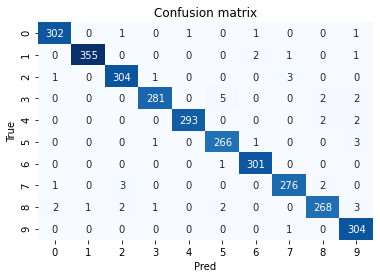

In [ ]:
## Plot multi-class metrics and confusion matrix 
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(metrics.classification_report(labels, preds))

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")

plt.show()